# Introduction


In this project we'll be performing sentiment analysis on Rotten Tomatoes Dataset whose dataset has been attached in this repo

The main task corresponds to a multi-class text classification on Movie Reviews Competition and the dataset contains 156,060 from which we have to classify among 5 classes. The sentiment labels are:

0 → Negative      </br>
1 → Somewhat negative  </br>
2 → Neutral </br>
3 → Somewhat positive </br>
4 → Positive </br>



We will be comparing performance of several algorithms and will deduce which works best

# Steps to be followed

1. Importing necessary libraries
2. Opening the train and test dataset in the form of pandas dataframe and perform exploratory data analysis on train data
3. Performing pre-processing 
4. Taking the train data and splitting it into train and val dataset ( test set is already given)
5. Applying different models </br>
   a) BERT </br>
   b) RoBERTa (Robustly Optimized BERT Pre-training Approach) </br>
5. Comparing performance of different models 
6. Final Analysis

### Step 1. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## other libraries will be imported as and when required

## Step 2. Opening the dataset and performing EDA

In [2]:
train_df = pd.read_csv('../input/sentimentdata/train.tsv/train.tsv' , sep='\t')
test_df = pd.read_csv('../input/sentimentdata/test.tsv/test.tsv' , sep = '\t')

In [3]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
print(train_df.shape)
#print(train_df.info)
print(train_df.columns)
print(train_df.isnull().sum())

(156060, 4)
Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64


In [5]:
train_df['Sentiment'].value_counts()


2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

<AxesSubplot:title={'center':'Pie chart of Sentiment Class'}, ylabel='Sentiment'>

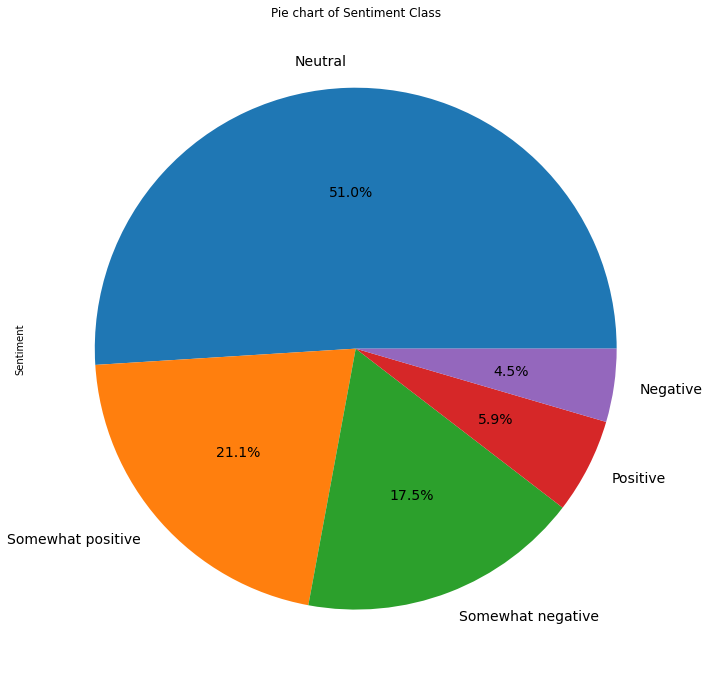

In [6]:
df2=train_df.copy(deep=True)
pie1=pd.DataFrame(df2['Sentiment'].replace(0,'Negative').replace(1,'Somewhat negative').replace(2,'Neutral').replace(3,'Somewhat positive').replace(4,'Positive').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Sentiment Class',y = 'Sentiment', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

***Insights*** <br>
There is an imbalance . So we cannot do random split, We'll do <tt>**StratifiedSplit()**</tt> to ensure distribution is same in splits

Text(0.5, 0.98, 'Histogram number of words in reviews')

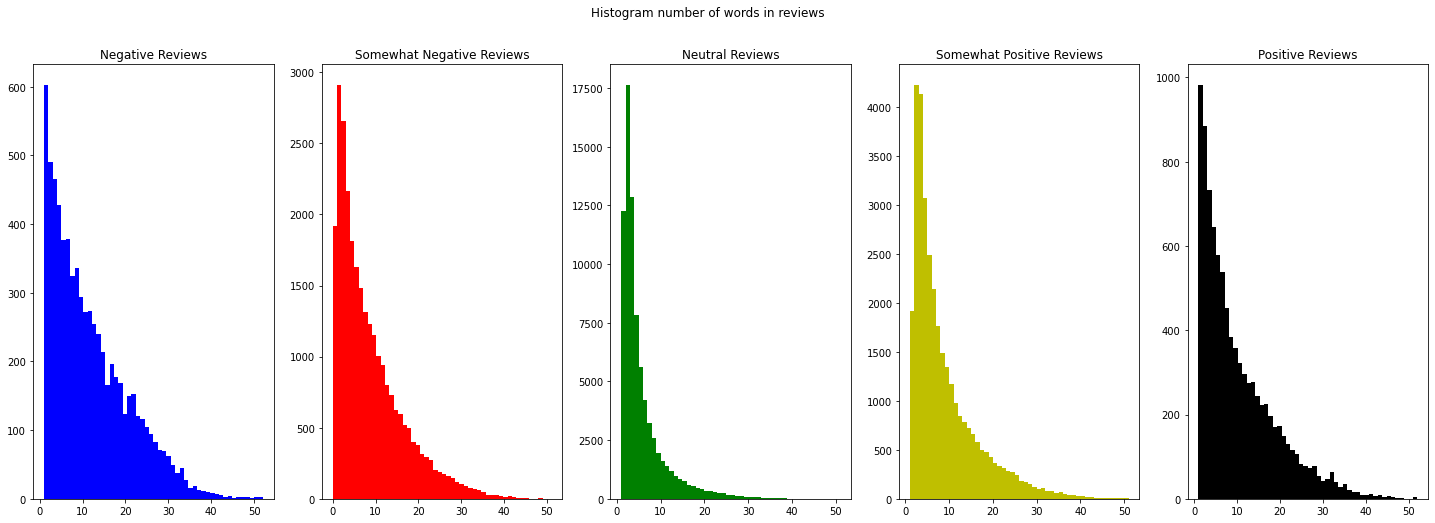

In [7]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))
ax1.hist(train_df[train_df['Sentiment'] == 0]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(train_df[train_df['Sentiment'] == 1]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(train_df[train_df['Sentiment'] == 2]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(train_df[train_df['Sentiment'] == 3]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(train_df[train_df['Sentiment'] == 4]['Phrase'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In [8]:
train_df['Phrase'].str.split().map(lambda x: len(x)).max()

52

***Insights*** <br>
Through these graphs we can see that most reviews of any class are of shorter length, around 5-20. But max length is 52 
Effectively was 52 words, this means if we would Tokenize by word the max_length should be 52, however as transformers consider sub-words tokenization such number could be increased depending on the words being used which can increase such length to 60 or even more, thus we have to take that into account when modeling as it could cause our model to take significatively a long time to train, therefore we have to find a trade-off between training time and performance.

In [9]:

df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
df=pd.DataFrame(train_df['Phrase'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', df.loc[df['Phrase']==True].shape[0])
print(' ')
#dfff.loc[dfff['Phrase']==True]

Number of sentences which contain more than 20 words:  11494
 
Number of sentences which contain more than 30 words:  2568
 
Number of sentences which contain more than 40 words:  352
 
Number of sentences which contain more than 50 words:  18
 
Number of sentences which contain 52 words:  3
 


***Insights*** <br>
We can remove sentences which have length more than 40 words and they won't contribute much but removing them can help to boost computation

In [10]:
train_df['len'] = train_df['Phrase'].str.split().map(lambda x: len(x))
print(train_df.shape)

train_df = train_df[train_df['len'] <40 ]
print(train_df.shape)

(156060, 5)
(155708, 5)


In [11]:
156060 - 155708

352

### Step 4. Taking the new data and splitting it into train and test (validation set will be made from train set later)

In [12]:
train_df['Sentiment'].value_counts()

2    79525
3    32810
1    27195
4     9146
0     7032
Name: Sentiment, dtype: int64

There is an imbalance . So we cannot do random split, We'll do <tt>**StratifiedSplit()**</tt> to ensure distribution is same in splits

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
X = train_df.drop('Sentiment',axis=1)
y = train_df['Sentiment']
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0) #test size of 10% 

for train_index, test_index in sss.split(X , y):  
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]  
    X_val = X.iloc[test_index]
    y_val = y.iloc[test_index]

In [14]:
print('Train distribution')
print(y_train.value_counts())
print(y_train.shape[0])
print("\n")
print('Val distribution')
print(y_val.value_counts())
print(y_val.shape[0])

Train distribution
2    71572
3    29529
1    24476
4     8231
0     6329
Name: Sentiment, dtype: int64
140137


Val distribution
2    7953
3    3281
1    2719
4     915
0     703
Name: Sentiment, dtype: int64
15571


In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

### Step 5. Applying Transformer Model
### a) BERT

In [16]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , EarlyStopping

import pandas as pd


In [17]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

model_name = 'bert-base-uncased'
max_length = 45

config = BertConfig.from_pretrained(model_name)
bert_tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name , config=config)
transformer_bert_model = TFBertModel.from_pretrained(model_name , config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-02-03 06:56:12.921038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 06:56:12.922226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 06:56:12.922930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 06:56:12.923867: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
sample_text = train_df['Phrase'][0]
print(sample_text)
print(bert_tokenizer(sample_text))

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
{'input_ids': [101, 1037, 2186, 1997, 9686, 17695, 18673, 14313, 1996, 15262, 3351, 2008, 2054, 2003, 2204, 2005, 1996, 13020, 2003, 2036, 2204, 2005, 1996, 25957, 4063, 1010, 2070, 1997, 2029, 5681, 2572, 25581, 2021, 3904, 1997, 2029, 8310, 2000, 2172, 1997, 1037, 2466, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


#### Building the model

In [19]:


input_ids = Input(shape = (max_length,) , name = 'input_ids' , dtype = 'int32')

#transformer_bert_model.trainable = False
# Load the Transformers BERT model as a layer in a Keras model
bert_model = transformer_bert_model(input_ids)[1]

dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)


# Then build your model output
Sentiments = Dense(units=5, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = Sentiments
bert_model = Model(inputs=input_ids, outputs=outputs, name='Bert-SentimentNetwork')


In [20]:
bert_model.summary()

Model: "Bert-SentimentNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 45)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


In [21]:
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}
bert_model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])



x_train = bert_tokenizer(
          text=X_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)



x_val = bert_tokenizer(
          text=X_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)


In [22]:
# callbacks = [
#     EarlyStopping(patience=5),
#     ReduceLROnPlateau(factor=0.3, patience=3, min_lr=0.00001 ),
#     ModelCheckpoint('bert_model.h5')
# ]

In [23]:
# Fit the model
history = bert_model.fit(
    x=x_train['input_ids'],
    y= y_train,
    validation_data=(x_val['input_ids'], y_val),
    batch_size=256,
    epochs=10,
    )

2022-02-03 06:56:36.837425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
548/548 [==============================] - 702s 1s/step - loss: 0.8239 - accuracy: 0.6610 - val_loss: 0.7354 - val_accuracy: 0.6958
Epoch 2/10
548/548 [==============================] - 664s 1s/step - loss: 0.7003 - accuracy: 0.7103 - val_loss: 0.7256 - val_accuracy: 0.6962
Epoch 3/10
548/548 [==============================] - 663s 1s/step - loss: 0.6682 - accuracy: 0.7230 - val_loss: 0.7238 - val_accuracy: 0.6971
Epoch 4/10
548/548 [==============================] - 663s 1s/step - loss: 0.6503 - accuracy: 0.7310 - val_loss: 0.7205 - val_accuracy: 0.6989
Epoch 5/10
548/548 [==============================] - 663s 1s/step - loss: 0.6390 - accuracy: 0.7371 - val_loss: 0.7208 - val_accuracy: 0.6983
Epoch 6/10
548/548 [==============================] - 663s 1s/step - loss: 0.6300 - accuracy: 0.7415 - val_loss: 0.7236 - val_accuracy: 0.6962
Epoch 7/10
548/548 [==============================] - 663s 1s/step - loss: 0.6232 - accuracy: 0.7444 - val_loss: 0.7207 - val_accuracy: 0.6987

In [24]:
y_val_pred = bert_model.predict(x_val['input_ids'])



In [25]:
y_val_pred.shape

(15571, 5)

In [26]:
y_val_pred_max = np.argmax(y_val_pred , axis = 1)
y_val_gt_max = np.argmax(y_val , axis = 1)

print(y_val_pred_max.shape)
print(y_val_gt_max.shape)


(15571,)
(15571,)


In [27]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(y_val_pred_max, y_val_gt_max)

print(report)

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       782
           1       0.63      0.58      0.60      2943
           2       0.78      0.81      0.79      7661
           3       0.59      0.62      0.61      3120
           4       0.64      0.55      0.59      1065

    accuracy                           0.69     15571
   macro avg       0.64      0.61      0.62     15571
weighted avg       0.69      0.69      0.69     15571



AxesSubplot(0.125,0.125;0.62x0.755)


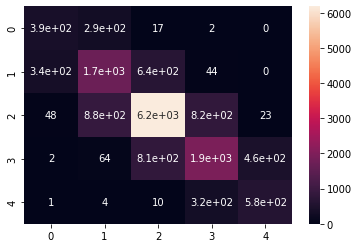

In [28]:
import seaborn as sns
print(sns.heatmap(confusion_matrix(y_val_gt_max , y_val_pred_max) , annot=True))

#### b) RoBERTa

In [29]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig 

model_name = 'roberta-base'
max_length = 40

config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

roberta_tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [30]:
input_ids = Input(shape = (max_length,) , name = 'input_ids' , dtype = 'int32')

#transformer_roberta_model.trainable = False
# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = transformer_roberta_model(input_ids)[1]

dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)


# Then build your model output
Sentiments = Dense(units=5, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Sentiment')(pooled_output)
outputs = Sentiments
roberta_model = Model(inputs=input_ids, outputs=outputs, name='RobBERTa_Sentiment')

In [31]:
roberta_model.summary()

Model: "RobBERTa_Sentiment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
tf_roberta_model (TFRobertaM TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Sentiment (Dense)            (None, 5)                 3845      
Total params: 124,649,477
Trainable params: 124,649,477
Non-trainable params: 0
_________________________________________________________________


In [32]:
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
loss = {'Sentiment': CategoricalCrossentropy(from_logits = True)}
roberta_model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

x_train = roberta_tokenizer(
          text=X_train['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)



x_val = roberta_tokenizer(
          text=X_val['Phrase'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

In [33]:
history = roberta_model.fit(
    x=x_train['input_ids'],
    y= y_train,
    validation_data=(x_val['input_ids'], y_val),
    batch_size=256,
    epochs=10,

)

Epoch 1/10
548/548 [==============================] - 625s 1s/step - loss: 0.8466 - accuracy: 0.6527 - val_loss: 0.7366 - val_accuracy: 0.6962
Epoch 2/10
548/548 [==============================] - 604s 1s/step - loss: 0.7160 - accuracy: 0.7029 - val_loss: 0.7326 - val_accuracy: 0.6910
Epoch 3/10
548/548 [==============================] - 604s 1s/step - loss: 0.6906 - accuracy: 0.7132 - val_loss: 0.7192 - val_accuracy: 0.6978
Epoch 4/10
548/548 [==============================] - 604s 1s/step - loss: 0.6747 - accuracy: 0.7200 - val_loss: 0.7302 - val_accuracy: 0.6902
Epoch 5/10
548/548 [==============================] - 604s 1s/step - loss: 0.6638 - accuracy: 0.7241 - val_loss: 0.7270 - val_accuracy: 0.6924
Epoch 6/10
548/548 [==============================] - 604s 1s/step - loss: 0.6561 - accuracy: 0.7285 - val_loss: 0.7191 - val_accuracy: 0.6989
Epoch 7/10
548/548 [==============================] - 604s 1s/step - loss: 0.6497 - accuracy: 0.7312 - val_loss: 0.7165 - val_accuracy: 0.7019

### Step 6. Evaluating performance of both models on val set

In [34]:
y_val_pred = roberta_model.predict(x_val['input_ids'])

In [35]:
y_val_pred.shape

(15571, 5)

In [36]:
y_val_pred_max = np.argmax(y_val_pred , axis = 1)
y_val_gt_max = np.argmax(y_val , axis = 1)

print(y_val_pred_max.shape)
print(y_val_gt_max.shape)

(15571,)
(15571,)


In [37]:
from sklearn.metrics import classification_report,confusion_matrix
report = classification_report(y_val_pred_max, y_val_gt_max)

print(report)

              precision    recall  f1-score   support

           0       0.53      0.52      0.53       713
           1       0.60      0.60      0.60      2737
           2       0.79      0.80      0.80      7855
           3       0.61      0.62      0.61      3208
           4       0.65      0.56      0.60      1058

    accuracy                           0.70     15571
   macro avg       0.64      0.62      0.63     15571
weighted avg       0.70      0.70      0.70     15571



AxesSubplot(0.125,0.125;0.62x0.755)


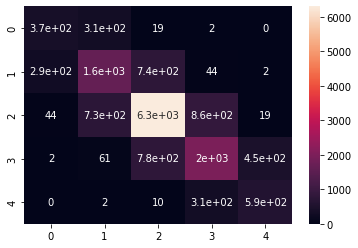

In [38]:
import seaborn as sns
print(sns.heatmap(confusion_matrix(y_val_gt_max , y_val_pred_max) , annot=True))